In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, regularizers, models
from keras.models import load_model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from util import save_history, save_model, plot_metrics, plot_visualizations

In [3]:
model_version = "v11.0"
base_model_version = 'v11.0'

In [4]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [5]:
with open('../data_schema.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [7]:
df = pd.read_csv(f"../data/processed/photometry_only.csv")

X = df[photo_cols + generic_cols]
y = df[target_col]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
inputs = keras.Input(shape=(X_train_scaled.shape[1],), name='New_Input')

# Layer 1
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(inputs)
x = layers.Activation('relu', name='Act_64')(x)
x = layers.Dropout(0.2, name='Dropout_64')(x)

# Layer 2
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(x)
x = layers.Activation('relu', name='Act_128')(x)
x = layers.Dropout(0.2, name='Dropout_128')(x)

# Layer 3
x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), name='Dense_256')(x)
x = layers.Activation('relu', name='Act_256')(x)
x = layers.Dropout(0.2, name='Dropout_256')(x)

# Layer 4
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128_2')(x)
x = layers.Activation('relu', name='Act_128_2')(x)
x = layers.Dropout(0.2, name='Dropout_128_2')(x)

outputs = layers.Dense(1, name='New_Output')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='Transfer_Learning_Model')

# === Step 2: Initialize and Load Weights ===
model.load_weights(f"../models/{base_model_version}/spec_photo_model.h5", 
                        by_name=True, 
                        skip_mismatch=True)

# === Step 3: Freeze Base Layers ===
model.get_layer('Dense_64').trainable = False
model.get_layer('Dense_128').trainable = False
model.get_layer('Dense_256').trainable = True
model.get_layer('Dense_128_2').trainable = True
    
# === Step 4: Compile the Model ===

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Use Huber loss to balance sensitivity to outliers
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.Huber(), 
              metrics=['mae', 'mse', 'mape'])

model.summary()

Model: "Transfer_Learning_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 New_Input (InputLayer)      [(None, 39)]              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                2560      
                                                                 
 Act_64 (Activation)         (None, 64)                0         
                                                                 
 Dropout_64 (Dropout)        (None, 64)                0         
                                                                 
 Dense_128 (Dense)           (None, 128)               8320      
                                                                 
 Act_128 (Activation)        (None, 128)               0         
                                                                 
 Dropout_128 (Dropout)       (None, 128)   

In [30]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_split=0.5, verbose=1, callbacks=[early_stopping])

Epoch 1/200
2792/2792 [==============================] - 21s 7ms/step - loss: 0.5777 - mae: 0.8814 - mse: 1.9842 - mape: 8.4105 - val_loss: 0.1875 - val_mae: 0.4088 - val_mse: 0.2915 - val_mape: 3.9618
Epoch 2/200
2792/2792 [==============================] - 20s 7ms/step - loss: 0.3761 - mae: 0.6731 - mse: 0.7296 - mape: 6.4486 - val_loss: 0.1762 - val_mae: 0.3830 - val_mse: 0.2659 - val_mape: 3.7502
Epoch 3/200
2792/2792 [==============================] - 20s 7ms/step - loss: 0.3432 - mae: 0.6314 - mse: 0.6473 - mape: 6.0633 - val_loss: 0.1748 - val_mae: 0.3768 - val_mse: 0.2617 - val_mape: 3.6990
Epoch 4/200
2792/2792 [==============================] - 21s 7ms/step - loss: 0.3241 - mae: 0.6064 - mse: 0.5998 - mape: 5.8311 - val_loss: 0.1748 - val_mae: 0.3852 - val_mse: 0.2581 - val_mape: 3.7326
Epoch 5/200
2792/2792 [==============================] - 21s 7ms/step - loss: 0.3063 - mae: 0.5822 - mse: 0.5568 - mape: 5.6041 - val_loss: 0.1733 - val_mae: 0.3749 - val_mse: 0.2598 - val_map

In [33]:
y_pred = model.predict(X_test_scaled)

1396/1396 [==============================] - 2s 1ms/step


In [34]:
plot_metrics(y_test, y_pred)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.3734
Root Mean Squared Error (RMSE): 0.5096
R² Score: 0.4037


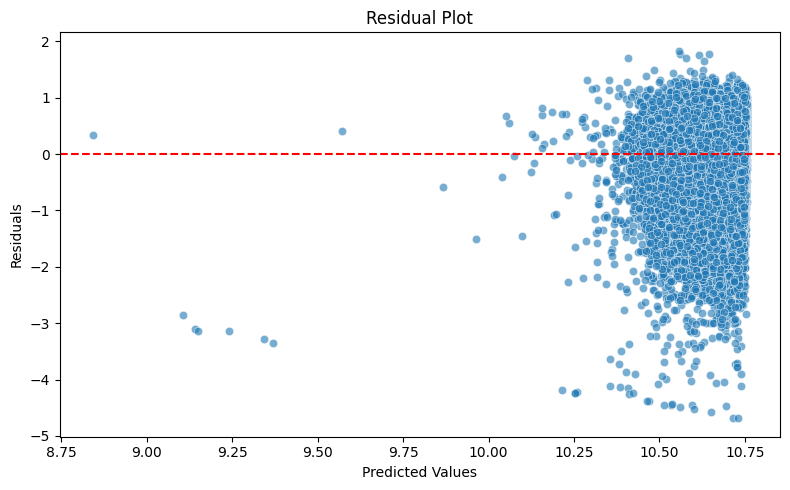

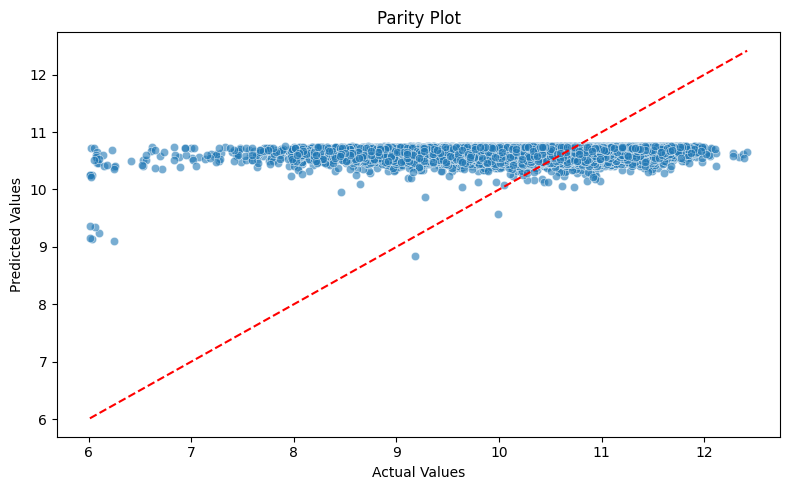

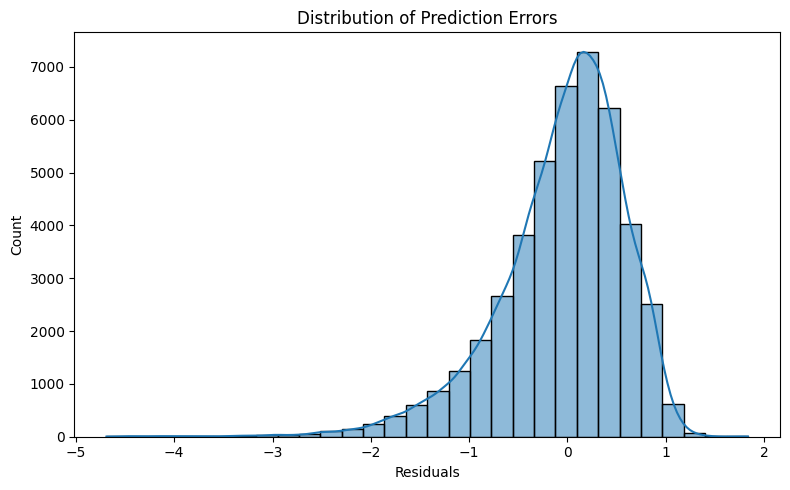

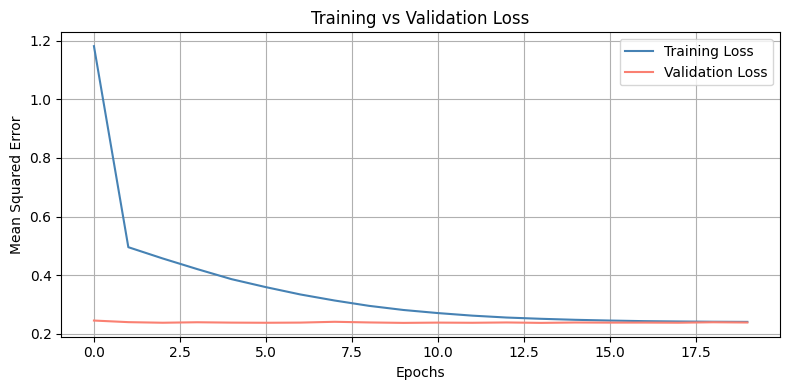

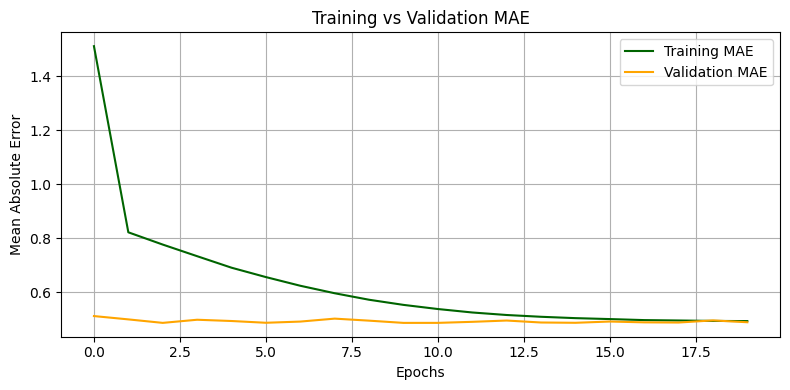

In [28]:
plot_visualizations(history, y_test, y_pred)

In [17]:
save_history(history, model_version, 'history_photo_only')

In [18]:
save_model(transfer_model, model_version, 'photo_only_model.h5')

In [19]:
df_unseen = pd.read_csv(f"../data/processed/unseen_data.csv")

X_unseen = df_unseen[photo_cols + generic_cols]
y_unseen = df_unseen[target_col]

In [20]:
X_unseen_scaled = scaler.transform(X_unseen)

In [21]:
y_pred_unseen = transfer_model.predict(X_unseen_scaled)

6980/6980 [==============================] - 15s 2ms/step


In [22]:
plot_metrics(y_unseen, y_pred_unseen)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.1043
Root Mean Squared Error (RMSE): 0.1957
R² Score: 0.9105


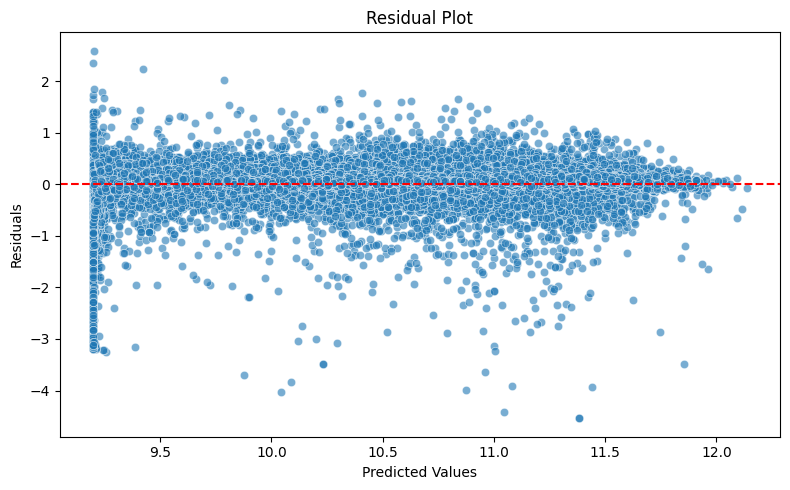

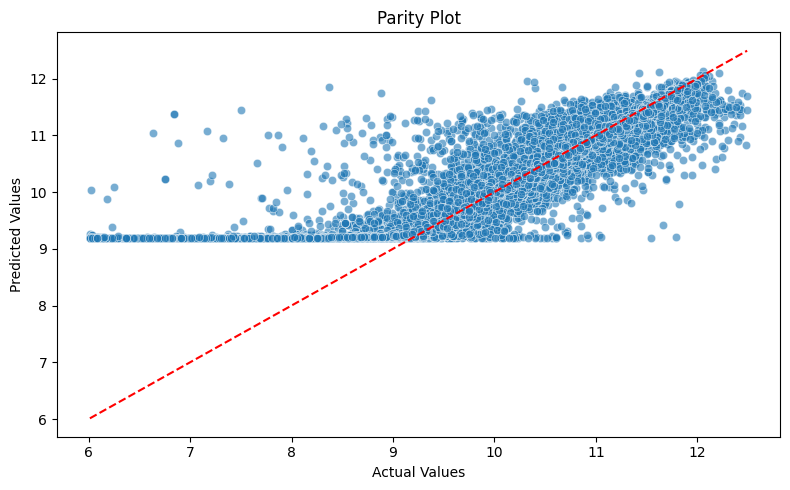

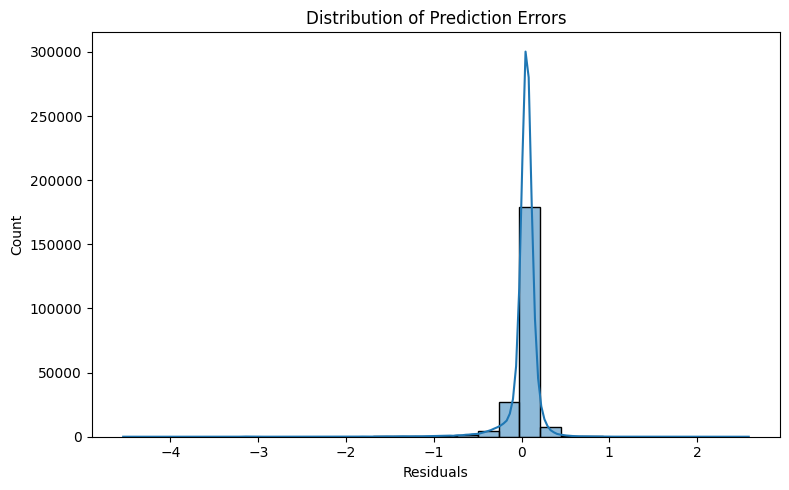

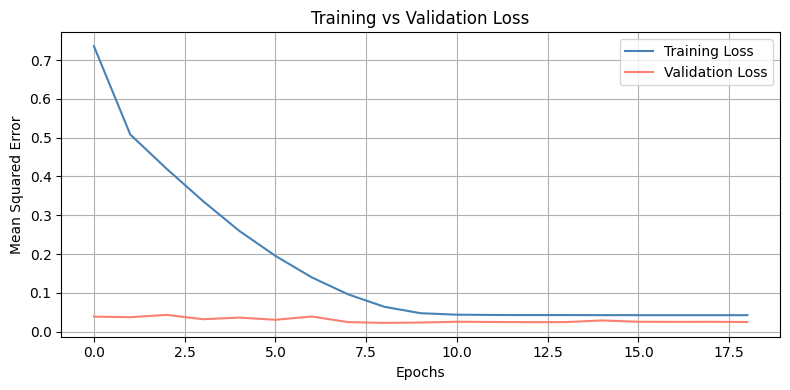

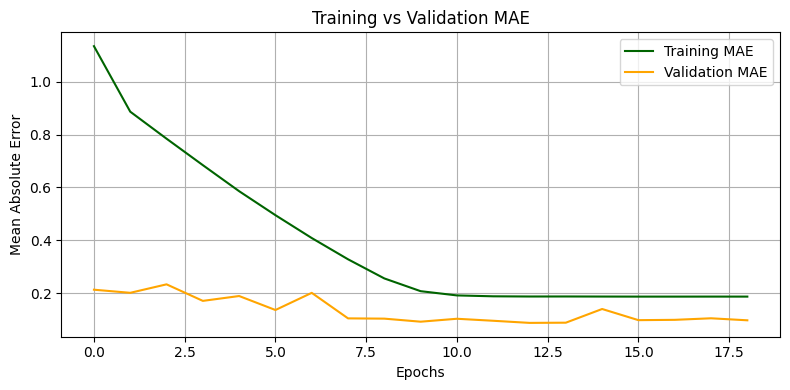

In [26]:
plot_visualizations(history, y_unseen, y_pred_unseen)